In [22]:
!pip install lbl2vec
from lbl2vec import Lbl2Vec

!pip install nlpaug
import nlpaug.augmenter.word as naw

!pip install emoji
import emoji

import time
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from ipywidgets import  interact
from collections import Counter


#NLTK y RE
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.collocations import BigramCollocationFinder, BigramAssocMeasures
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.probability import FreqDist
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

#GENSIM
import gensim
from gensim import corpora
from gensim.models import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from gensim.matutils import Sparse2Corpus
from gensim.models import Doc2Vec

#SKLEARN
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer, HashingVectorizer
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, MeanShift, SpectralClustering
from sklearn.decomposition import TruncatedSVD

from sklearn.model_selection import train_test_split, cross_validate, KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression, RidgeClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import (accuracy_score, mean_absolute_error, mean_squared_error,
                             classification_report, confusion_matrix, ConfusionMatrixDisplay,
                             homogeneity_score, completeness_score, v_measure_score,
                             adjusted_rand_score, rand_score, silhouette_score,
                             precision_recall_fscore_support)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#lbl2Vec para Corpus Balanceados

In [26]:
# Función para crear documentos gensim Doc2Vec
def create_doc2vec_documents(df):
    documents = []
    for i, row in df.iterrows():
        words = row["text"].split()
        tags = [row["label"]]  # Usar una lista para la etiqueta
        document = gensim.models.doc2vec.TaggedDocument(words, tags)
        documents.append(document)
    return documents
def remove_non_alphabetic(text):
    return ''.join([char for char in text if char.isalpha() or char.isspace() or emoji.is_emoji(char)])

# Algoritmo de preprocesamiento
def preprocess_text(df):

    stop_words = set(stopwords.words('english'))

    # Convertir los textos a minúsculas
    df["text"] = df["text"].str.lower()

    # Eliminar caracteres no alfabéticos, manteniendo emojis
    df["text"] = df["text"].apply(remove_non_alphabetic)

    # Eliminar stop-words
    df["text"] = df["text"].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

    return df

# Aplicar el preprocesamiento al DataFrame
#df = preprocess_text(df)

# Inicializar Stemmer y Lemmatizer
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

# Función para hacer stemming y lematización
def stem_and_lemmatize(text):
    tokens = nltk.word_tokenize(text)
    stemmed = [stemmer.stem(token) for token in tokens]
    lemmatized = [lemmatizer.lemmatize(token) for token in stemmed]
    return ' '.join(lemmatized)

# Aplicar stemming y lematización al DataFrame
#df["text"] = df["text"].apply(stem_and_lemmatize)
def evaluate_model(y_test, y_pred, labels, display_labels):
    # Reset indices to ensure alignment
    y_test = y_test.reset_index(drop = True)
    y_pred = y_pred.reset_index(drop = True)

    correct_labels = sum(y_test == y_pred)
    print("Se etiquetaron correctamente %d de un total de %d muestras." % (correct_labels, y_test.size))
    # Imprimir MAE y RMSE
    print("Errores")
    print(f"MAE: {np.round(mean_absolute_error(y_test, y_pred), 3)}")
    print(f"MSE: {np.round(np.sqrt(mean_squared_error(y_test, y_pred)), 3)}")
    print("\n")

    # Imprimir el reporte de clasificación
    print(classification_report(y_test, y_pred))

    # Mostrar la matriz de confusión
    cm = confusion_matrix(y_test, y_pred, labels=labels)
    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels).plot()
    plt.show()

### Para SEXISMO

In [51]:
df = pd.read_csv("/content/drive/MyDrive/NLP/Corpus/sexism_data.csv")
df = df.drop(columns=["toxicity","id", "dataset", "of_id"]) #no son nenecsarias
df["sexist"].replace({True:1, False:0},inplace=True)#reemplazamos 1 = True, 0=false
df = df.rename(columns = {"sexist":"label"})

#Data Augmentation
# Calculamos el número de augmentaciones necesarias
num_majority = df['label'].value_counts()[0]
num_minority = df['label'].value_counts()[1]
num_augmentations = num_majority - num_minority

# Usamos nlpaug para hacer data augmentation en la columna 'text'
aug = naw.SynonymAug(aug_src='wordnet')

def augment_text(text, augmenter, n_augmentations=1):
    augmented_texts = [augmenter.augment(text) for _ in range(n_augmentations)]
    return augmented_texts

# Aplicamos augmentación a los textos etiquetados como 'Hate'
df_sexism = df[df['label'] == 1]
augmented_texts = []

for text in df_sexism['text']:
    augmented_texts.extend(augment_text(text, aug, n_augmentations=int(num_augmentations/num_minority)))

# Creamos un DataFrame con los textos aumentados
df_augmented = pd.DataFrame(augmented_texts, columns=['text'])
df_augmented['label'] = 1

# Concatenar los textos aumentados con el dataset original
df_sexista = pd.concat([df, df_augmented])


#limpiamos texto para cubrirnos en salud y aplicamos lematizado y stemming
df_sexista = preprocess_text(df_sexista)
# Función para hacer stemming y lematización
df_sexista['Lematizado_Stemming'] = df_sexista['text'].apply(stem_and_lemmatize)

tagged_documents = create_doc2vec_documents(df_sexista)
df_sexista.insert(len(df_sexista.columns),"tagged_documents", tagged_documents)
# add doc_key column
df_sexista["doc_key"] = df_sexista.index.astype(str)
df_sexista.head()

,text,label,Lematizado_Stemming,tagged_documents,doc_key
0,mention didnt even know random option,0,mention didnt even know random option,"([mention, didnt, even, know, random, option],...",0
1,bottom two shouldve gone mkr,0,bottom two shouldv gone mkr,"([bottom, two, shouldve, gone, mkr], [0])",1
2,mention mention ladyboner deserves much credit...,0,mention mention ladybon deserv much credit dud...,"([mention, mention, ladyboner, deserves, much,...",2
3,shall known sourpuss mkr katandre failedfoodies,0,shall known sourpuss mkr katandr failedfoodi,"([shall, known, sourpuss, mkr, katandre, faile...",3
4,tarah w threw bunch women bus could get wadhwa...,0,tarah w threw bunch woman bu could get wadhwa ...,"([tarah, w, threw, bunch, women, bus, could, g...",4


In [52]:
# Etiquetas
label_names = {0: 'NO sexist', 1: 'sexist'}

# Función para obtener las palabras clave
def get_keywords(df, label):
    texts = df[df['label'] == label]['Lematizado_Stemming']
    all_words = ' '.join(texts).split()   # Concatenar todos los textos y separar las palabras
    freq_dist = FreqDist(all_words) # Calcular la distribución de frecuencia de las palabras
    common_words = freq_dist.most_common() #freq_dist.most_common(n) get_keywords(df, label, n)
    keywords = [word for word, _ in common_words]
    return keywords, len(keywords)


# Crear el DataFrame final
label_data = []
for label in df_sexista['label'].unique():
    keywords, num_keywords = get_keywords(df_sexista, label) #get_keywords(df_sexista, label,n)
    label_data.append({
        'label': label,
        'label_name': label_names[label],
        'keywords': keywords,
        'number_of_keywords': num_keywords
    })

df_labels = pd.DataFrame(label_data)


In [53]:
df_sexista = df_sexista.merge(df_labels, left_on="label", right_on="label", how="left").drop(['keywords'], axis=1)
df_sexista.head()

,text,label,Lematizado_Stemming,tagged_documents,doc_key,label_name,number_of_keywords
0,mention didnt even know random option,0,mention didnt even know random option,"([mention, didnt, even, know, random, option],...",0,NO sexist,11736
1,bottom two shouldve gone mkr,0,bottom two shouldv gone mkr,"([bottom, two, shouldve, gone, mkr], [0])",1,NO sexist,11736
2,mention mention ladyboner deserves much credit...,0,mention mention ladybon deserv much credit dud...,"([mention, mention, ladyboner, deserves, much,...",2,NO sexist,11736
3,shall known sourpuss mkr katandre failedfoodies,0,shall known sourpuss mkr katandr failedfoodi,"([shall, known, sourpuss, mkr, katandre, faile...",3,NO sexist,11736
4,tarah w threw bunch women bus could get wadhwa...,0,tarah w threw bunch woman bu could get wadhwa ...,"([tarah, w, threw, bunch, women, bus, could, g...",4,NO sexist,11736


In [54]:
df_sexista_train, df_sexista_test = train_test_split(df_sexista, test_size = 0.2, random_state = 123, stratify=df_sexista["label"])

df_sexista_train["data_set_type"] = "train"

df_sexista_test["data_set_type"] = "test"

# concatenamos
df_sexista_full = pd.concat([df_sexista_train,df_sexista_test]).reset_index(drop=True)
df_sexista_full.head()

,text,label,Lematizado_Stemming,tagged_documents,doc_key,label_name,number_of_keywords,data_set_type
0,place mkr mkr,0,place mkr mkr,"([place, mkr, mkr], [0])",9037,NO sexist,11736,train
1,drasko steve david margret restaurant reviews mkr,0,drasko steve david margret restaur review mkr,"([drasko, steve, david, margret, restaurant, r...",12667,NO sexist,11736,train
2,heres review games ive ever played fuck misogy...,0,here review game ive ever play fuck misogynist...,"([heres, review, games, ive, ever, played, fuc...",1787,NO sexist,11736,train
3,creates isolation needed longerterm campaigns ...,0,creat isol need longerterm campaign threaten a...,"([creates, isolation, needed, longerterm, camp...",2634,NO sexist,11736,train
4,deconstructed lemon tart plate crushed biscuit...,0,deconstruct lemon tart plate crush biscuit mkr,"([deconstructed, lemon, tart, plate, crushed, ...",12935,NO sexist,11736,train


In [55]:
start_time = time.time()
lbl2vec_model_sexism = Lbl2Vec(keywords_list = list(df_labels["keywords"]),
                          tagged_documents = df_sexista_full['tagged_documents'][df_sexista_full['data_set_type']=='train'],
                         label_names = list(df_labels["label_name"]),
                         similarity_threshold = 0.9, #0.001, 0.01, 0.1, 0.5, 0.9
                         epochs = 10
                         )
# train model
lbl2vec_model_sexism.fit()
# test
new_docs_lbl_similarities_sexism = lbl2vec_model_sexism.predict_new_docs(tagged_docs = df_sexista_full['tagged_documents'][df_sexista_full['data_set_type']=='test'])
end_time = time.time()
print(f"Tiempo de ejecución: {end_time - start_time} segundos")

2024-06-13 17:10:09,190 - Lbl2Vec - INFO - Train document and word embeddings
2024-06-13 17:10:09,190 - Lbl2Vec - INFO - Train document and word embeddings
2024-06-13 17:10:09,190 - Lbl2Vec - INFO - Train document and word embeddings
2024-06-13 17:10:09,190 - Lbl2Vec - INFO - Train document and word embeddings
INFO:Lbl2Vec:Train document and word embeddings
2024-06-13 17:10:27,753 - Lbl2Vec - INFO - Train label embeddings
2024-06-13 17:10:27,753 - Lbl2Vec - INFO - Train label embeddings
2024-06-13 17:10:27,753 - Lbl2Vec - INFO - Train label embeddings
2024-06-13 17:10:27,753 - Lbl2Vec - INFO - Train label embeddings
INFO:Lbl2Vec:Train label embeddings
2024-06-13 17:10:28,147 - Lbl2Vec - WARNING - The following keywords from the 'keywords_list' are unknown to the Doc2Vec model and therefore not used to train the model: peopl realli andr that your someon tri pretti everi footbal mani sorri someth anoth happi alway anyon ye actual gamerg comment there theyr rooki harass restaur happen not

Tiempo de ejecución: 40.07835936546326 segundos


In [56]:
df_pred = new_docs_lbl_similarities_sexism.copy(deep = True)
df_pred.rename(columns = {"most_similar_label":"label"}, inplace = True)
df_pred["label"].replace({"NO sexist":0, "sexist":1}, inplace = True)
df_pred["label"].value_counts()

label
0    4536
Name: count, dtype: int64

Se etiquetaron correctamente 2365 de un total de 4536 muestras.
Errores
MAE: 0.479
MSE: 0.692


              precision    recall  f1-score   support

           0       0.52      1.00      0.69      2365
           1       0.00      0.00      0.00      2171

    accuracy                           0.52      4536
   macro avg       0.26      0.50      0.34      4536
weighted avg       0.27      0.52      0.36      4536



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


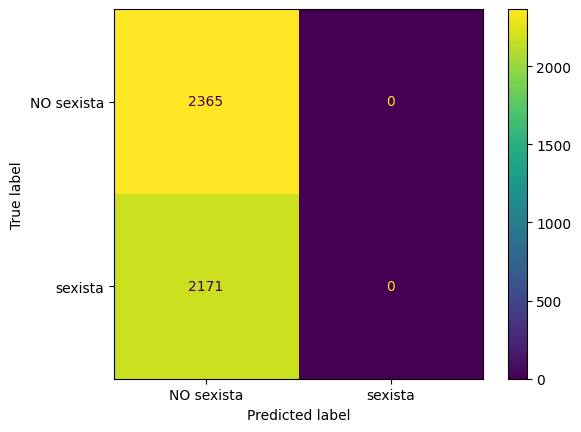

In [57]:
categories = ["NO sexista", "sexista"]
y_test = df_sexista_test["label"].astype(int)
y_pred_test = df_pred["label"].astype(int)

evaluate_model(y_test, y_pred_test, labels= np.unique(df_sexista_full["label"]), display_labels = categories)

### Para Odio RELATION

In [58]:
#df ODIO REL
df = pd.read_csv("/content/drive/MyDrive/NLP/Corpus/df_odio.csv")
df = df.drop(columns=["user_id", "subforum_id", "num_contexts"])
df = df.drop((df[df["label"] == 2]).index)
df['label'].replace(3, 1, inplace = True) #Le decimos al sistema que trate la etiqueta Relation como Hate

#Data Augmentation
# Calculamos el número de augmentaciones necesarias
num_majority = df['label'].value_counts()[0]
num_minority = df['label'].value_counts()[1]
num_augmentations = num_majority - num_minority

# Usamos nlpaug para hacer data augmentation en la columna 'text'
aug = naw.SynonymAug(aug_src='wordnet')

def augment_text(text, augmenter, n_augmentations=1):
    augmented_texts = [augmenter.augment(text) for _ in range(n_augmentations)]
    return augmented_texts

# Aplicamos augmentación a los textos etiquetados como 'Hate'
df_sexism = df[df['label'] == 1]
augmented_texts = []

for text in df_sexism['text']:
    augmented_texts.extend(augment_text(text, aug, n_augmentations=int(num_augmentations/num_minority)))

# Creamos un DataFrame con los textos aumentados
df_augmented = pd.DataFrame(augmented_texts, columns=['text'])
df_augmented['label'] = 1

# Concatenar los textos aumentados con el dataset original
df_odio_relation = pd.concat([df, df_augmented])


#limpiamos texto para cubrirnos en salud y aplicamos lematizado y stemming
df_odio_relation = preprocess_text(df_odio_relation)
# Función para hacer stemming y lematización
df_odio_relation['Lematizado_Stemming'] = df_odio_relation['text'].apply(stem_and_lemmatize)

tagged_documents = create_doc2vec_documents(df_odio_relation)
df_odio_relation.insert(len(df_odio_relation.columns),"tagged_documents", tagged_documents)
# add doc_key column
df_odio_relation["doc_key"] = df_odio_relation.index.astype(str)
df_odio_relation.head()

,text,label,Lematizado_Stemming,tagged_documents,doc_key
0,march th booklet downloaded times counting,0,march th booklet download time count,"([march, th, booklet, downloaded, times, count...",0
1,order help increase booklets downloads would g...,0,order help increas booklet download would grea...,"([order, help, increase, booklets, downloads, ...",1
2,simply copy paste following text youtube video...,0,simpli copi past follow text youtub video desc...,"([simply, copy, paste, following, text, youtub...",2
3,click free download colorfully illustrated pag...,1,click free download color illustr page ebook z...,"([click, free, download, colorfully, illustrat...",3
4,click download mb green banner link,0,click download mb green banner link,"([click, download, mb, green, banner, link], [0])",4


In [59]:
# Etiquetas
label_names = {0: 'NO hate', 1: 'hate'}

# Función para obtener las palabras clave
def get_keywords(df, label):
    texts = df[df['label'] == label]['Lematizado_Stemming']
    all_words = ' '.join(texts).split()   # Concatenar todos los textos y separar las palabras
    freq_dist = FreqDist(all_words) # Calcular la distribución de frecuencia de las palabras
    common_words = freq_dist.most_common() #freq_dist.most_common(n) get_keywords(df, label, n)
    keywords = [word for word, _ in common_words]
    return keywords, len(keywords)


# Crear el DataFrame final
label_data = []
for label in df_odio_relation['label'].unique():
    keywords, num_keywords = get_keywords(df_odio_relation, label) #get_keywords(df_odio_relation, label,n)
    label_data.append({
        'label': label,
        'label_name': label_names[label],
        'keywords': keywords,
        'number_of_keywords': num_keywords
    })

df_labels = pd.DataFrame(label_data)

In [60]:
df_odio_relation = df_odio_relation.merge(df_labels, left_on="label", right_on="label", how="left").drop(['keywords'], axis=1)
df_odio_relation_train, df_odio_relation_test = train_test_split(df_odio_relation, test_size = 0.2, random_state = 123, stratify=df_odio_relation["label"])

df_odio_relation_train["data_set_type"] = "train"

df_odio_relation_test["data_set_type"] = "test"

# concatenamos
df_odio_relation_full = pd.concat([df_odio_relation_train,df_odio_relation_test]).reset_index(drop=True)
df_odio_relation_full.head()

,text,label,Lematizado_Stemming,tagged_documents,doc_key,label_name,number_of_keywords,data_set_type
0,httpwwwvgnopubvgarthbs artid suspected warcrim...,0,httpwwwvgnopubvgarthb artid suspect warcrim se...,"([httpwwwvgnopubvgarthbs, artid, suspected, wa...",1410,NO hate,10580,train
1,surprisingly one said anything,0,surprisingli one said anyth,"([surprisingly, one, said, anything], [0])",8254,NO hate,10580,train
2,hiring someone website ensure practise n hire ...,1,hire someon websit ensur practis n hire undesir,"([hiring, someone, website, ensure, practise, ...",374,hate,7097,train
3,looking day realized kids probably get go get ...,0,look day realiz kid probabl get go get check e...,"([looking, day, realized, kids, probably, get,...",3299,NO hate,10580,train
4,matter greater extent disgusting white adult f...,1,matter greater extent disgust white adult fema...,"([matter, greater, extent, disgusting, white, ...",2486,hate,7097,train


In [61]:
start_time = time.time()

lbl2vec_model_odio_relation = Lbl2Vec(keywords_list = list(df_labels["keywords"]),
                          tagged_documents = df_odio_relation_full['tagged_documents'][df_odio_relation_full['data_set_type']=='train'],
                         label_names = list(df_labels["label_name"]),
                         similarity_threshold = 0.9, #0.001, 0.01, 0.1, 0.5, 0.9
                         epochs = 10
                         )
# train model
lbl2vec_model_odio_relation.fit()
# test
new_docs_lbl_similarities_odio_relation = lbl2vec_model_odio_relation.predict_new_docs(tagged_docs = df_odio_relation_full['tagged_documents'][df_odio_relation_full['data_set_type']=='test'])
end_time = time.time()
print(f"Tiempo de ejecución: {end_time - start_time} segundos")

2024-06-13 17:12:46,261 - Lbl2Vec - INFO - Train document and word embeddings
2024-06-13 17:12:46,261 - Lbl2Vec - INFO - Train document and word embeddings
2024-06-13 17:12:46,261 - Lbl2Vec - INFO - Train document and word embeddings
2024-06-13 17:12:46,261 - Lbl2Vec - INFO - Train document and word embeddings
2024-06-13 17:12:46,261 - Lbl2Vec - INFO - Train document and word embeddings
INFO:Lbl2Vec:Train document and word embeddings
2024-06-13 17:12:56,056 - Lbl2Vec - INFO - Train label embeddings
2024-06-13 17:12:56,056 - Lbl2Vec - INFO - Train label embeddings
2024-06-13 17:12:56,056 - Lbl2Vec - INFO - Train label embeddings
2024-06-13 17:12:56,056 - Lbl2Vec - INFO - Train label embeddings
2024-06-13 17:12:56,056 - Lbl2Vec - INFO - Train label embeddings
INFO:Lbl2Vec:Train label embeddings
2024-06-13 17:12:56,328 - Lbl2Vec - WARNING - The following keywords from the 'keywords_list' are unknown to the Doc2Vec model and therefore not used to train the model: peopl youtub mani tri anyo

Tiempo de ejecución: 18.843857288360596 segundos


In [62]:
df_pred = new_docs_lbl_similarities_odio_relation.copy(deep = True)
df_pred.rename(columns = {"most_similar_label":"label"}, inplace = True)
df_pred["label"].replace({"NO hate":0, "hate":1}, inplace = True)
df_pred["label"].value_counts()

label
0    3539
Name: count, dtype: int64

Se etiquetaron correctamente 1902 de un total de 3539 muestras.
Errores
MAE: 0.463
MSE: 0.68


              precision    recall  f1-score   support

           0       0.54      1.00      0.70      1902
           1       0.00      0.00      0.00      1637

    accuracy                           0.54      3539
   macro avg       0.27      0.50      0.35      3539
weighted avg       0.29      0.54      0.38      3539



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


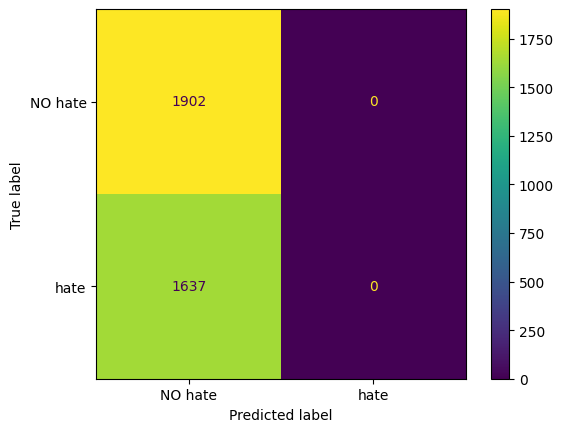

In [63]:
categories = ["NO hate", "hate"]
y_test = df_odio_relation_test["label"].astype(int)
y_pred_test = df_pred["label"].astype(int)

evaluate_model(y_test, y_pred_test, labels= np.unique(df_odio_relation["label"]), display_labels = categories)

### Para ODIO SIN RELATION

In [43]:
#Pasamos las func en df_sexist
df = pd.read_csv("/content/drive/MyDrive/NLP/Corpus/df_odio.csv")
df = df.drop(columns=["user_id", "subforum_id", "num_contexts"])
df = df.drop((df[df["label"] == 2]).index)
df = df.drop((df[df["label"] >= 2]).index)

#Data Augmentation
# Calculamos el número de augmentaciones necesarias
num_majority = df['label'].value_counts()[0]
num_minority = df['label'].value_counts()[1]
num_augmentations = num_majority - num_minority

# Usamos nlpaug para hacer data augmentation en la columna 'text'
aug = naw.SynonymAug(aug_src='wordnet')

def augment_text(text, augmenter, n_augmentations=1):
    augmented_texts = [augmenter.augment(text) for _ in range(n_augmentations)]
    return augmented_texts

# Aplicamos augmentación a los textos etiquetados como 'Hate'
df_sexism = df[df['label'] == 1]
augmented_texts = []

for text in df_sexism['text']:
    augmented_texts.extend(augment_text(text, aug, n_augmentations=int(num_augmentations/num_minority)))

# Creamos un DataFrame con los textos aumentados
df_augmented = pd.DataFrame(augmented_texts, columns=['text'])
df_augmented['label'] = 1

# Concatenar los textos aumentados con el dataset original
df_odio_NOrelation = pd.concat([df, df_augmented])


#limpiamos texto para cubrirnos en salud y aplicamos lematizado y stemming
df_odio_NOrelation = preprocess_text(df_odio_NOrelation)
# Función para hacer stemming y lematización
df_odio_NOrelation['Lematizado_Stemming'] = df_odio_NOrelation['text'].apply(stem_and_lemmatize)

#Pasamos las func en
tagged_documents = create_doc2vec_documents(df_odio_NOrelation)
df_odio_NOrelation.insert(len(df_odio_NOrelation.columns),"tagged_documents", tagged_documents)
# add doc_key column
df_odio_NOrelation["doc_key"] = df_odio_NOrelation.index.astype(str)
df_odio_NOrelation.head()

,text,label,Lematizado_Stemming,tagged_documents,doc_key
0,march th booklet downloaded times counting,0,march th booklet download time count,"([march, th, booklet, downloaded, times, count...",0
1,order help increase booklets downloads would g...,0,order help increas booklet download would grea...,"([order, help, increase, booklets, downloads, ...",1
2,simply copy paste following text youtube video...,0,simpli copi past follow text youtub video desc...,"([simply, copy, paste, following, text, youtub...",2
3,click free download colorfully illustrated pag...,1,click free download color illustr page ebook z...,"([click, free, download, colorfully, illustrat...",3
4,click download mb green banner link,0,click download mb green banner link,"([click, download, mb, green, banner, link], [0])",4


In [ ]:
##doc2vec_model
# Definir y entrenar el modelo Doc2Vec
model_odio_rel = Doc2Vec(vector_size = 100,
                window = 5,
                min_count = 100,
                workers = 4,
                epochs = 20)
model_odio_rel.build_vocab(tagged_documents)
model_odio_rel.train(tagged_documents, total_examples=model_odio_rel.corpus_count, epochs=model_odio_rel.epochs)

# Guardar el modelo entrenado
model_odio_rel.save("Doc2Vec_ODIO_NOREL")

# Cargar el modelo (si es necesario)
model_odio_rel = Doc2Vec.load("Doc2Vec_ODIO_NOREL")

In [44]:
# Etiquetas
label_names = {0: 'NO hate', 1: 'hate'}

# Función para obtener las palabras clave
def get_keywords(df, label):
    texts = df[df['label'] == label]['Lematizado_Stemming']
    all_words = ' '.join(texts).split()   # Concatenar todos los textos y separar las palabras
    freq_dist = FreqDist(all_words) # Calcular la distribución de frecuencia de las palabras
    common_words = freq_dist.most_common() #freq_dist.most_common(n) get_keywords(df, label, n)
    keywords = [word for word, _ in common_words]
    return keywords, len(keywords)


# Crear el DataFrame final
label_data = []
for label in df_odio_NOrelation['label'].unique():
    keywords, num_keywords = get_keywords(df_odio_NOrelation, label) #get_keywords(df_odio_relation, label,n)
    label_data.append({
        'label': label,
        'label_name': label_names[label],
        'keywords': keywords,
        'number_of_keywords': num_keywords
    })

df_labels = pd.DataFrame(label_data)
df_labels

,label,label_name,keywords,number_of_keywords
0,0,NO hate,"[white, like, nt, peopl, get, one, youtub, wou...",10580
1,1,hate,"[white, black, n, inform, technolog, like, get...",7129


In [45]:
df_odio_NOrelation = df_odio_NOrelation.merge(df_labels, left_on="label", right_on="label", how="left").drop(['keywords'], axis=1)

In [46]:
df_odio_NOrelation_train, df_odio_NOrelation_test = train_test_split(df_odio_NOrelation, test_size = 0.2, random_state = 123, stratify=df_odio_NOrelation["label"])

df_odio_NOrelation_train["data_set_type"] = "train"

df_odio_NOrelation_test["data_set_type"] = "test"

# concatenamos
df_odio_NOrelation_full = pd.concat([df_odio_NOrelation_train,df_odio_NOrelation_test]).reset_index(drop=True)
df_odio_NOrelation_full.head()

,text,label,Lematizado_Stemming,tagged_documents,doc_key,label_name,number_of_keywords,data_set_type
0,hell cares kosher,1,hell care kosher,"([hell, cares, kosher], [1])",195,hate,7129,train
1,dont really blacks schools round,0,dont realli black school round,"([dont, really, blacks, schools, round], [0])",6605,NO hate,10580,train
2,like always said say till dying day beyond,0,like alway said say till die day beyond,"([like, always, said, say, till, dying, day, b...",6977,NO hate,10580,train
3,yeah possibly jewish warm old money impression...,1,yeah possibl jewish warm old money impress pre...,"([yeah, possibly, jewish, warm, old, money, im...",3800,hate,7129,train
4,always considered teaching one professions one...,1,alway consid teach one profess one would like ...,"([always, considered, teaching, one, professio...",13,hate,7129,train


In [47]:
df_odio_NOrelation_full['label'][df_odio_NOrelation_full['data_set_type']=='train'].value_counts()

label
0    7605
1    6698
Name: count, dtype: int64

In [48]:
start_time = time.time()

lbl2vec_model_odio_NOrelation = Lbl2Vec(keywords_list = list(df_labels["keywords"]),
                          tagged_documents = df_odio_NOrelation_full['tagged_documents'][df_odio_NOrelation_full['data_set_type']=='train'],
                         label_names = list(df_labels["label_name"]),
                         similarity_threshold = 0.5, #0.001, 0.01, 0.1, 0.5, 0.9
                         epochs = 10
                         )
# train model
lbl2vec_model_odio_NOrelation.fit()
# test
new_docs_lbl_similarities_odio_NOrelation = lbl2vec_model_odio_NOrelation.predict_new_docs(tagged_docs = df_odio_NOrelation_full['tagged_documents'][df_odio_NOrelation_full['data_set_type']=='test'])
end_time = time.time()
print(f"Tiempo de ejecución: {end_time - start_time} segundos")

2024-06-13 17:01:20,942 - Lbl2Vec - INFO - Train document and word embeddings
2024-06-13 17:01:20,942 - Lbl2Vec - INFO - Train document and word embeddings
2024-06-13 17:01:20,942 - Lbl2Vec - INFO - Train document and word embeddings
INFO:Lbl2Vec:Train document and word embeddings
2024-06-13 17:01:33,641 - Lbl2Vec - INFO - Train label embeddings
2024-06-13 17:01:33,641 - Lbl2Vec - INFO - Train label embeddings
2024-06-13 17:01:33,641 - Lbl2Vec - INFO - Train label embeddings
INFO:Lbl2Vec:Train label embeddings
2024-06-13 17:01:33,972 - Lbl2Vec - WARNING - The following keywords from the 'keywords_list' are unknown to the Doc2Vec model and therefore not used to train the model: peopl youtub mani tri anyon countri everi friend alway eye realli someth someon anyth mayb littl happen ye actual http anoth noth famili plea citi pictur hous stori welcom gun differ interest brother sinc el believ togeth pretti commun colleg seem polic student member idea messag report parent cultur mix chang be

Tiempo de ejecución: 19.97380495071411 segundos


In [ ]:
#new_docs_lbl_similarities_odio_relation.head()
new_docs_lbl_similarities_odio_relation.value_counts("most_similar_label")
#new_docs_lbl_similarities_odio_relation.info()

most_similar_label
NO hate    2175
Name: count, dtype: int64

In [49]:
df_pred = new_docs_lbl_similarities_odio_NOrelation.copy(deep = True)
df_pred.rename(columns = {"most_similar_label":"label"}, inplace = True)
df_pred["label"].replace({"NO hate":0, "hate":1}, inplace = True)
df_pred["label"].value_counts()

label
0    3576
Name: count, dtype: int64

In [ ]:
def evaluate_model(y_test, y_pred, labels, display_labels):
    # Reset indices to ensure alignment
    y_test = y_test.reset_index(drop = True)
    y_pred = y_pred.reset_index(drop = True)

    correct_labels = sum(y_test == y_pred)
    print("Se etiquetaron correctamente %d de un total de %d muestras." % (correct_labels, y_test.size))
    # Imprimir MAE y RMSE
    print("Errores")
    print(f"MAE: {np.round(mean_absolute_error(y_test, y_pred), 3)}")
    print(f"MSE: {np.round(np.sqrt(mean_squared_error(y_test, y_pred)), 3)}")
    print("\n")

    # Imprimir el reporte de clasificación
    print(classification_report(y_test, y_pred))

    # Mostrar la matriz de confusión
    cm = confusion_matrix(y_test, y_pred, labels=labels)
    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels).plot()
    plt.show()

In [ ]:
df_odio_NOrelation_test["label"].shape

(2141,)

Se etiquetaron correctamente 1902 de un total de 3576 muestras.
Errores
MAE: 0.468
MSE: 0.684


              precision    recall  f1-score   support

           0       0.53      1.00      0.69      1902
           1       0.00      0.00      0.00      1674

    accuracy                           0.53      3576
   macro avg       0.27      0.50      0.35      3576
weighted avg       0.28      0.53      0.37      3576



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


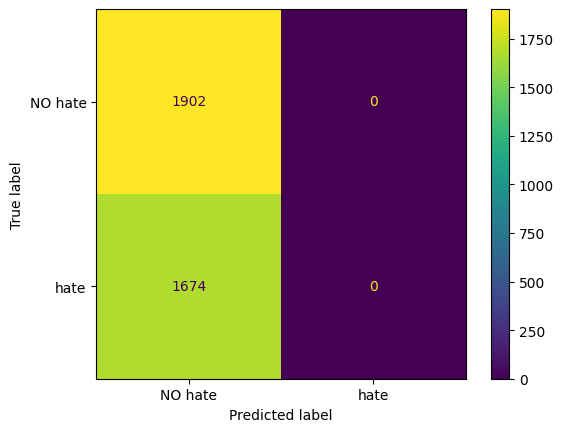

In [50]:
categories = ["NO hate", "hate"]
y_test = df_odio_NOrelation_test["label"].astype(int)
y_pred_test = df_pred["label"].astype(int)

evaluate_model(y_test, y_pred_test, labels= np.unique(df_odio_NOrelation["label"]), display_labels = categories)